In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from autowriter.datasets import OmniglotGridDataset, get_raw_omniglot_dataset
from autowriter.plotting import plot_motor_to_image, plot_encoded_moves
from autowriter.mingpt.model import GPT
from configs import AutoWriterConfig

In [2]:
plt.set_cmap('cividis')
sns.set_theme()

<Figure size 640x480 with 0 Axes>

In [3]:
config = AutoWriterConfig()

train_dataset = OmniglotGridDataset(('.'+config.omniglot_dir),
                                    context_len=config.context_len,
                                    char_idxs=config.character_idxs)

model_config = GPT.get_default_config()
# model_config.model_type = 'gpt-mini'#config.gpt_type
model_config.model_type = None
model_config.n_layer = config.n_layer
model_config.n_head = config.n_head
model_config.n_embd =  config.n_embd
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

model_filename = '../models/draw_gpt_state_dict_l_o_v7.pt'
state_dict = torch.load(model_filename, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()
print('loaded')

number of parameters: 9.53M
loaded


In [4]:
img_dir = Path('../datasets/omniglot/images/images_background/Latin/')
stroke_dir = Path('../datasets/omniglot/traces/strokes_background/Latin/')

raw_omniglot = get_raw_omniglot_dataset(stroke_dir, img_dir)
n_characters = len([x for x in img_dir.glob('*')])

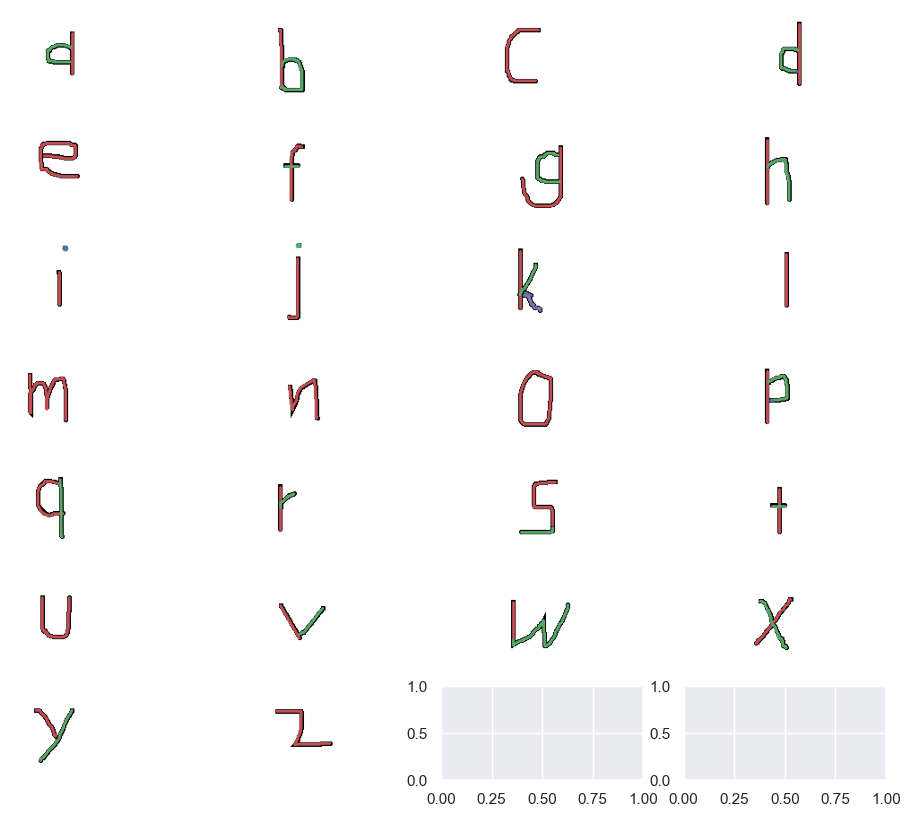

In [175]:
n_cols = 4
n_rows = int(np.ceil(n_characters / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))
for char_idx in range(n_characters):
    row_idx = char_idx // n_cols
    col_idx = char_idx % n_cols
    ax = axs[row_idx, col_idx]
    plot_motor_to_image(raw_omniglot[char_idx]['img'][0], raw_omniglot[char_idx]['motor'][0], ax, lw=2)

In [6]:
# Move indices:
# 0: left, 1: down, 2: right, 3: up

In [5]:
len(train_dataset.data)

480

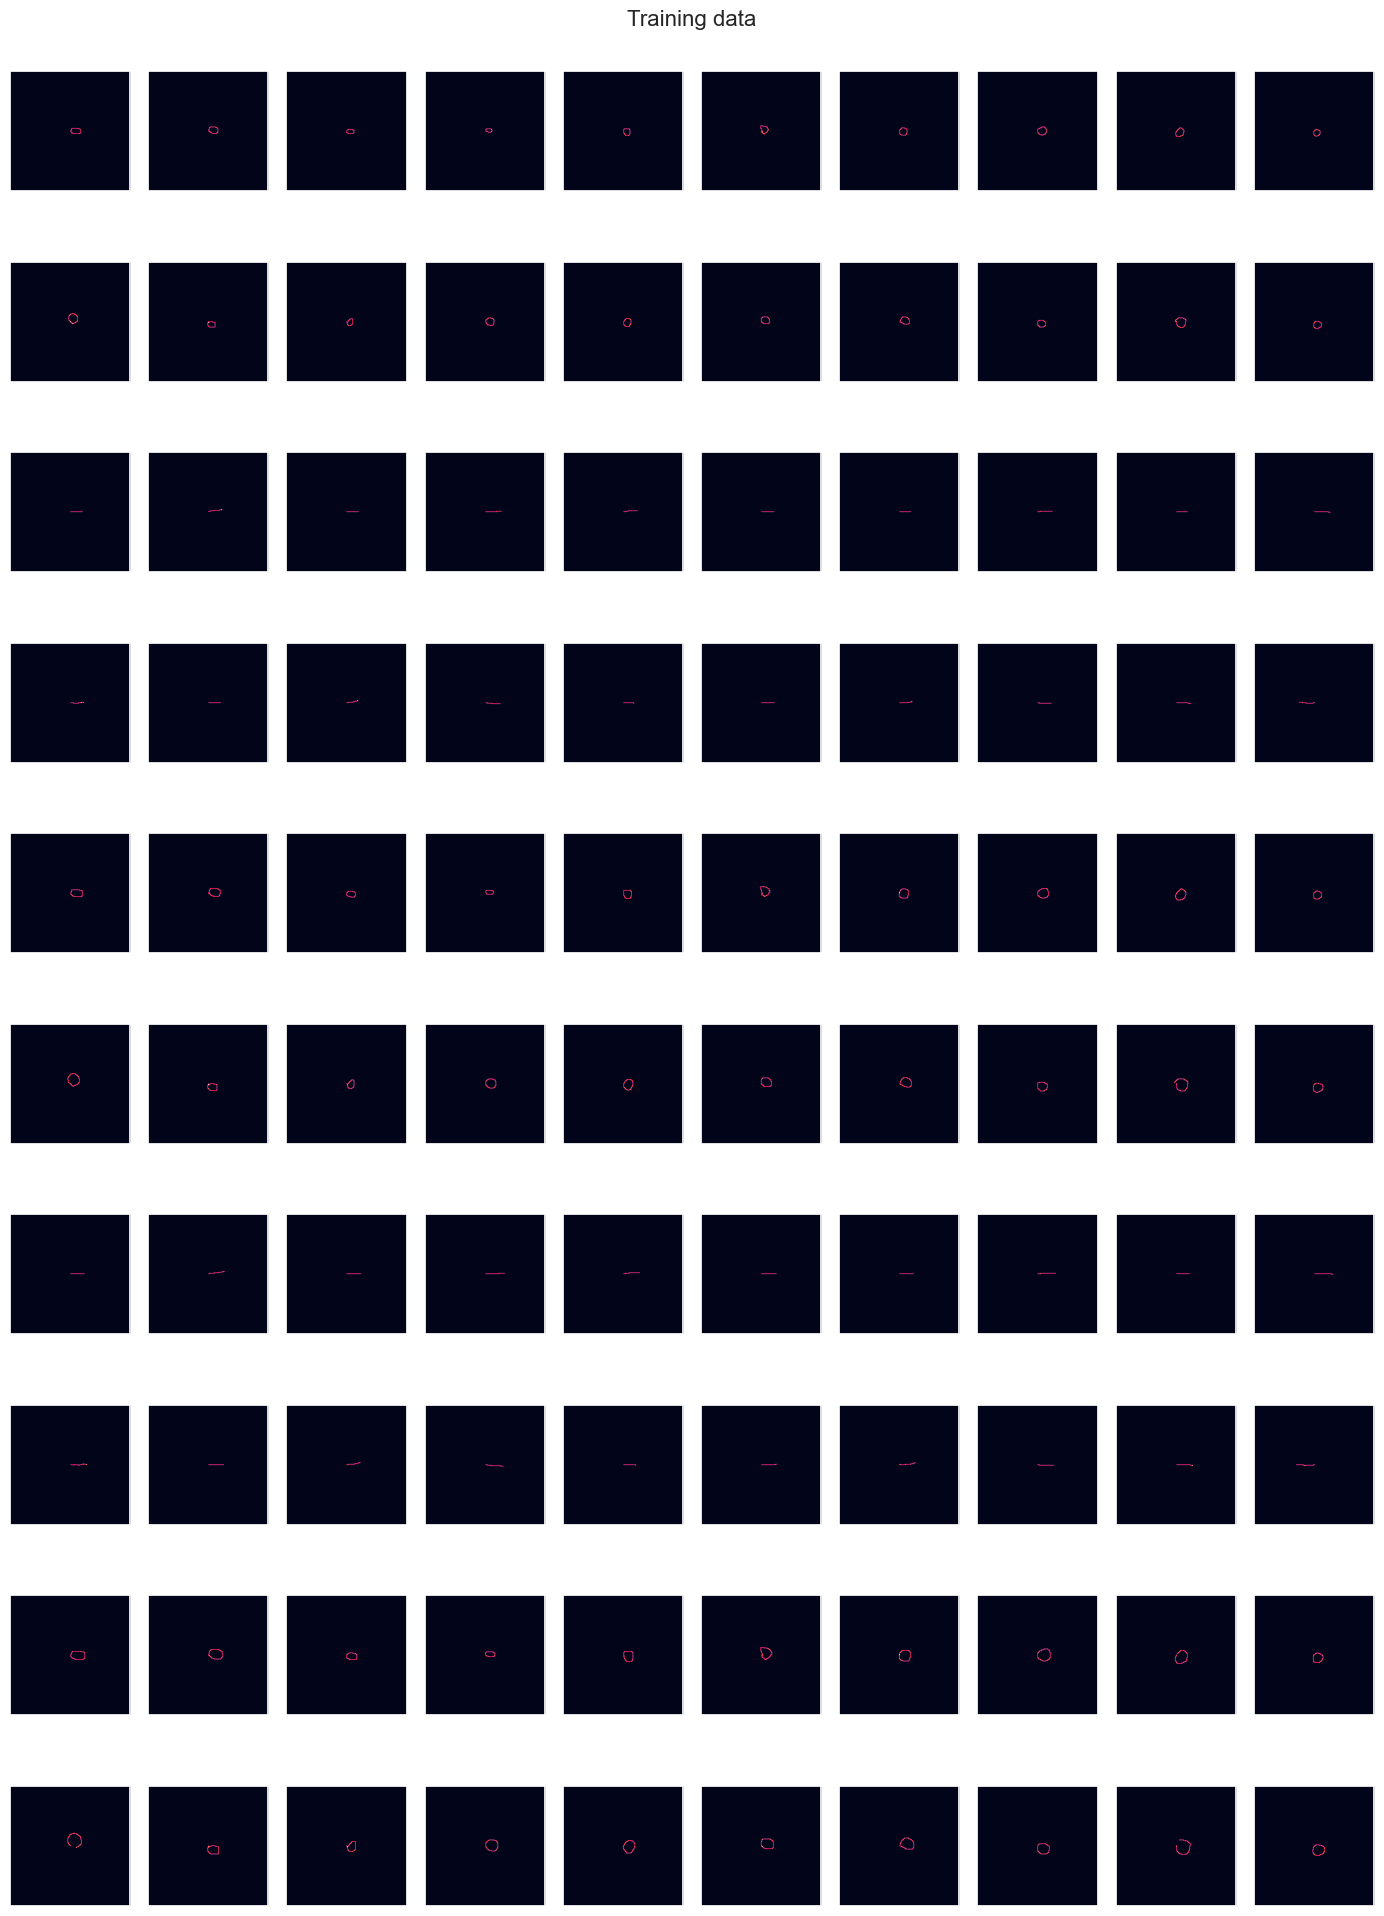

In [7]:
plot_data = train_dataset.data[-100:]
n_cols = 10
n_rows = int(np.ceil(len(plot_data) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,20))
for i, stroke in enumerate(plot_data):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]
    plot_encoded_moves(stroke, canvas_size=250, ax=ax)

fig.suptitle('Training data', fontsize=16)
plt.tight_layout()

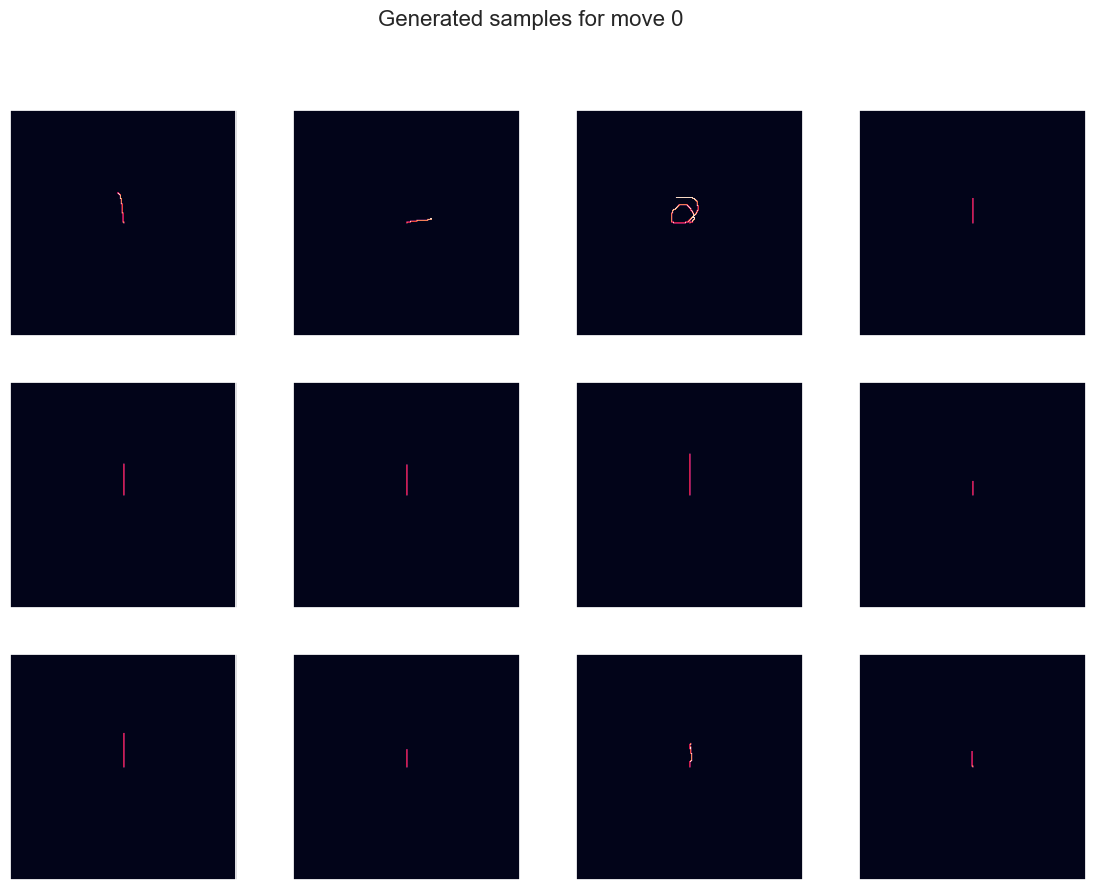

In [12]:
n_samples = 12
start_tokens = torch.tensor([0], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 0', fontsize=16)
plt.show()

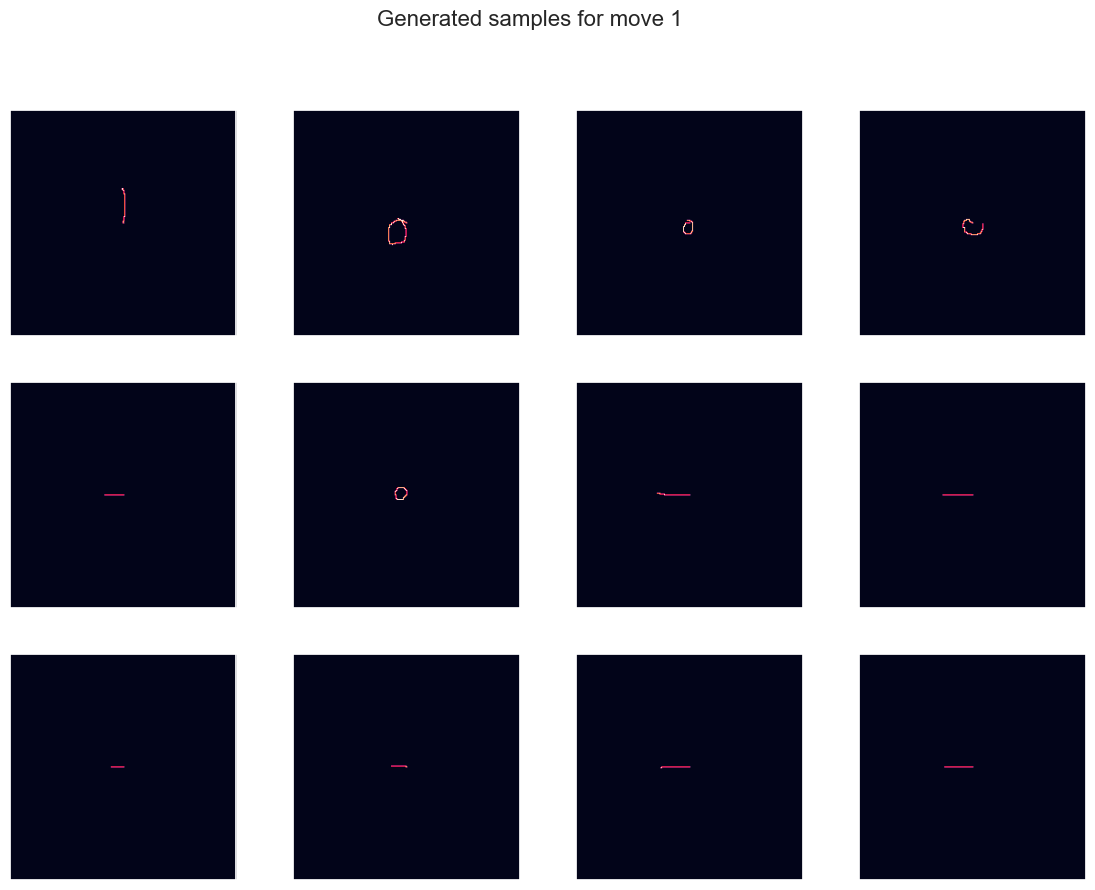

In [13]:
n_samples = 12
start_tokens = torch.tensor([1], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 1', fontsize=16)
plt.show()

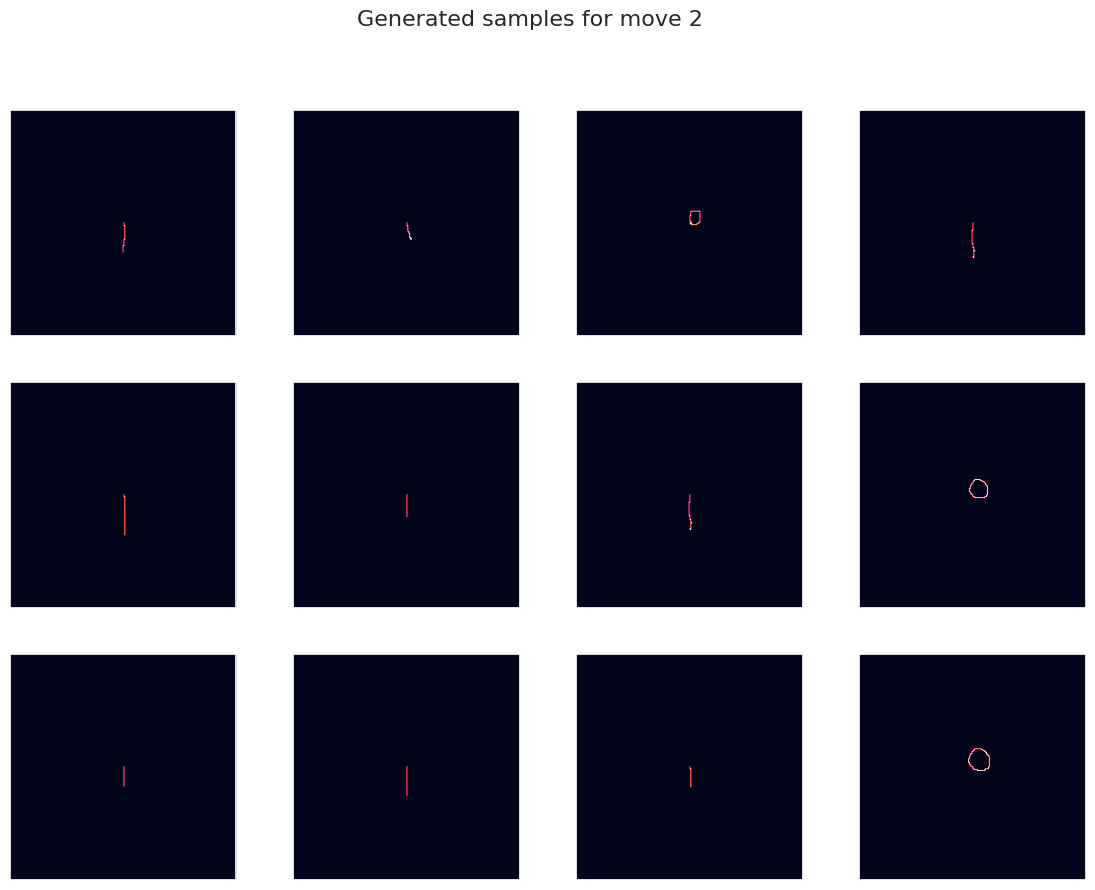

In [13]:
n_samples = 12
start_tokens = torch.tensor([2], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 2', fontsize=16)
plt.show()

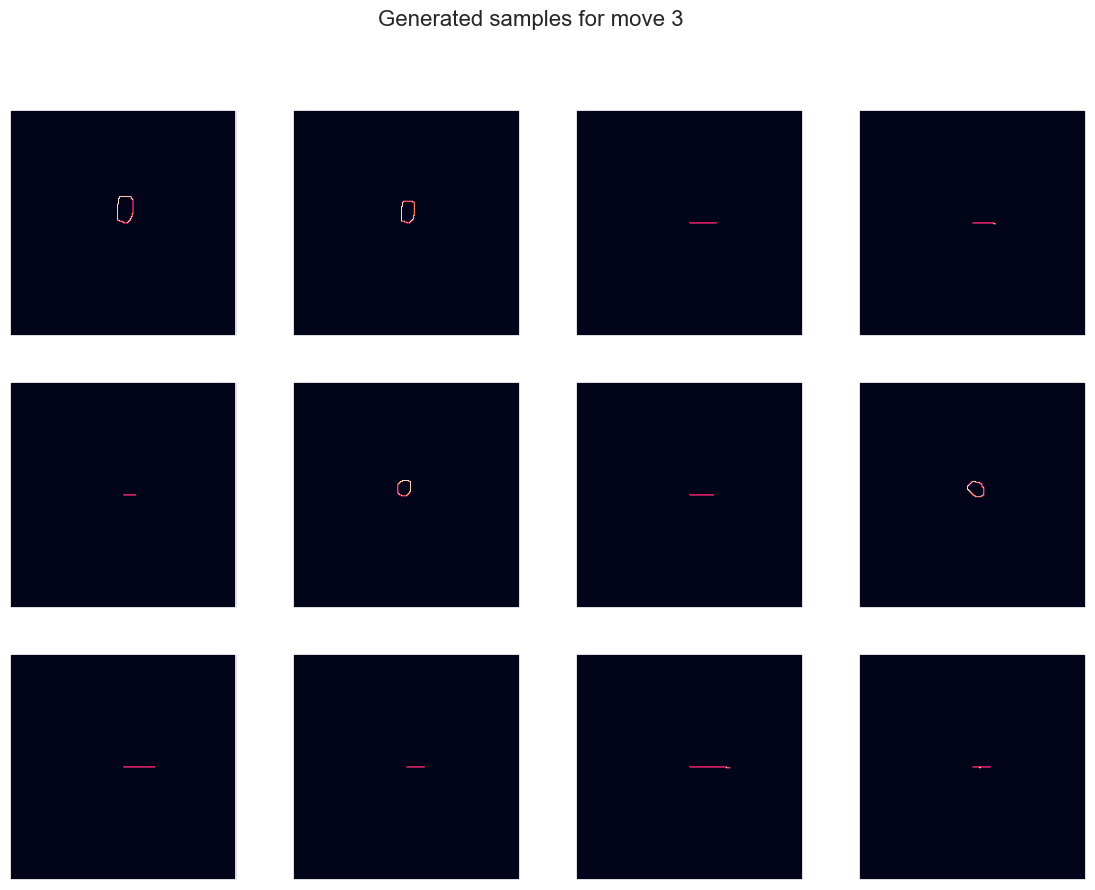

In [31]:
n_samples = 12
start_tokens = torch.tensor([3], dtype=torch.long)

n_cols = 4
n_rows = int(np.ceil(n_samples / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14,10))
for i in range(n_samples):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axs[row_idx, col_idx]

    out = model.generate(start_tokens.unsqueeze(0), 150, do_sample=True)[0]
    idx = torch.where(out == 4)[0]
    if len(idx) > 0:
        out = out[:idx.min()]
    plot_encoded_moves(out, canvas_size=250, ax=ax)

fig.suptitle('Generated samples for move 3', fontsize=16)
plt.show()

# Error correction

In [4]:
import torch
import torch.nn.functional as F
import torch.distributions as D

In [5]:
targets = torch.tensor([1,3,2])

In [26]:
class_mean = .5
other_mean = .2
class_std = .2
class_dist = D.Normal(class_mean, class_std)
other_dist = D.Normal(other_mean, class_std)

In [27]:
def get_noisy_logits(targets, class_dist, other_dist):
    onehot_targets = F.one_hot(targets, num_classes=4)
    noisy_targets = onehot_targets.clone().type(torch.float32)
    noisy_targets[noisy_targets == 1] = class_dist.sample(noisy_targets[noisy_targets == 1].shape)
    noisy_targets[noisy_targets == 0] = other_dist.sample(noisy_targets[noisy_targets == 0].shape)
    return noisy_targets

def simulate_strokes(stroke, num_steps, beta, do_sample=False):
    history = [stroke[0]]
    emg_only_hist = [stroke[0]]
    auto_only_hist = [stroke[0]]
    for i in range(num_steps):
        if i == len(stroke) - 1 or stroke[i+1] == 4:
            break
        targets = torch.tensor(stroke[i+1])
        emg_logits = get_noisy_logits(targets, class_dist, other_dist)
        tensor_history = torch.tensor(history, dtype=torch.long).unsqueeze(0)
        _, raw_auto_logits = model.generate(tensor_history, 1, return_logits=True)
        auto_logits = raw_auto_logits[-1, :4]

        logits = emg_logits + beta * auto_logits
        probs = F.softmax(logits, dim=-1)

        if do_sample:
            idx_next = torch.multinomial(probs)
        else:
            idx_next = probs.argmax(dim=-1)

        emg_next = F.softmax(emg_logits, dim=-1).argmax(dim=-1)

        tensor_auto_history = torch.tensor(auto_only_hist, dtype=torch.long).unsqueeze(0)
        _, raw_auto_only_logits = model.generate(tensor_auto_history, 1, return_logits=True)
        auto_next = F.softmax(raw_auto_only_logits[-1, :4], dim=-1).argmax(dim=-1)

        history.append(idx_next.item())
        emg_only_hist.append(emg_next.item())
        auto_only_hist.append(auto_next.item())

    return history, emg_only_hist, auto_only_hist

n_iters = 1000
accs = torch.zeros(n_iters)
for i in range(n_iters):
    noisy_logits = get_noisy_logits(targets, class_dist, other_dist)
    noisy_preds = F.softmax(noisy_logits, dim=-1).argmax(dim=-1)

    accs[i] = (noisy_preds == targets).type(torch.float32).mean()
accs.mean()

tensor(0.7060)

In [28]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

In [29]:
# load sample from dataset
num_steps = 200
do_sample = False
# beta = .005
betas = torch.arange(0.0 , 0.2, step=0.01)
beta_accs = {}
for beta in betas:
    accs = defaultdict(list)
    bar = tqdm(train_dataset.data[:40])
    for stroke in bar:
        history, emg_only_hist, auto_only_hist = simulate_strokes(stroke, num_steps, beta, do_sample=do_sample)
        accuracy = (stroke[stroke<4] == torch.tensor(history, dtype=torch.long)).type(torch.float32).mean()
        emg_accuracy = (stroke[stroke<4] == torch.tensor(emg_only_hist, dtype=torch.long)).type(torch.float32).mean()
        auto_accuracy = (stroke[stroke<4] == torch.tensor(auto_only_hist, dtype=torch.long)).type(torch.float32).mean()

        bar.set_description(f"acc: {accuracy:.2f}")

        accs['comb'].append(accuracy)
        accs['emg'].append(emg_accuracy)
        accs['auto'].append(auto_accuracy)

    for key, value in accs.items():
        accs[key] = np.mean(value)
    beta_accs[beta] = accs

  0%|          | 0/40 [00:00<?, ?it/s]/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_87310/3545633153.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(stroke[i+1])
acc: 0.24: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


Text(0.5, 0, 'beta')

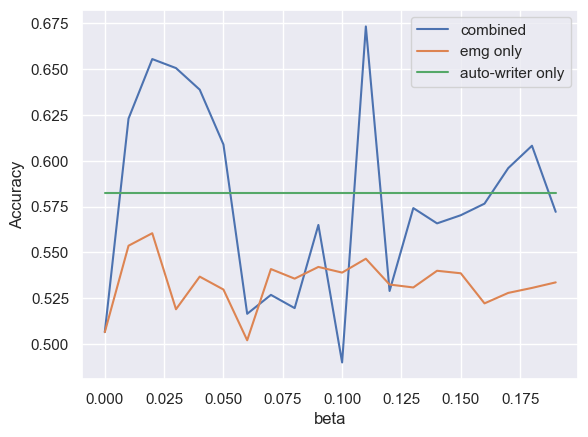

In [16]:
# v7
comb = [accs['comb'] for accs in beta_accs.values()]
emg = [accs['emg'] for accs in beta_accs.values()]
auto = [accs['auto'] for accs in beta_accs.values()]
x = betas.numpy()
plt.plot(x, comb, label='combined')
plt.plot(x, emg, label='emg only')
plt.plot(x, auto, label='auto-writer only')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('beta')

Text(0.5, 0, 'beta')

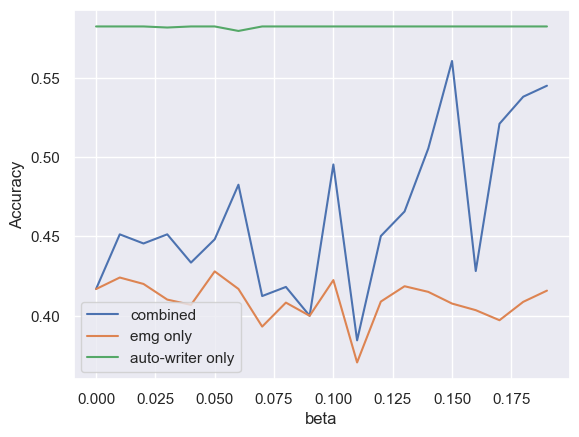

In [ ]:
comb = [accs['comb'] for accs in beta_accs.values()]
emg = [accs['emg'] for accs in beta_accs.values()]
auto = [accs['auto'] for accs in beta_accs.values()]
x = betas.numpy()
plt.plot(x, comb, label='combined')
plt.plot(x, emg, label='emg only')
plt.plot(x, auto, label='auto-writer only')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('beta')

Text(0.5, 0, 'beta')

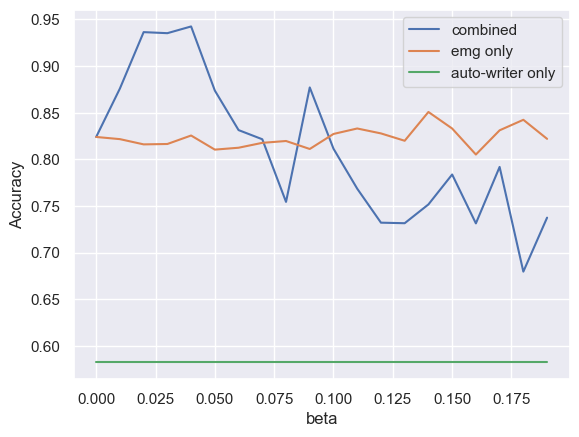

In [21]:
# v7
comb = [accs['comb'] for accs in beta_accs.values()]
emg = [accs['emg'] for accs in beta_accs.values()]
auto = [accs['auto'] for accs in beta_accs.values()]
x = betas.numpy()
plt.plot(x, comb, label='combined')
plt.plot(x, emg, label='emg only')
plt.plot(x, auto, label='auto-writer only')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('beta')

Text(0.5, 0, 'beta')

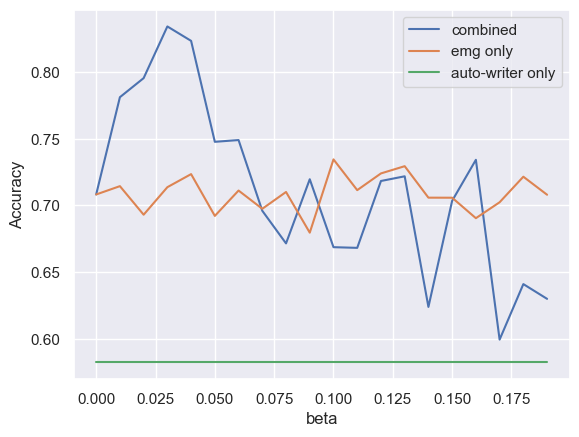

In [30]:
# v7
comb = [accs['comb'] for accs in beta_accs.values()]
emg = [accs['emg'] for accs in beta_accs.values()]
auto = [accs['auto'] for accs in beta_accs.values()]
x = betas.numpy()
plt.plot(x, comb, label='combined')
plt.plot(x, emg, label='emg only')
plt.plot(x, auto, label='auto-writer only')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('beta')

Text(0.5, 0, 'beta')

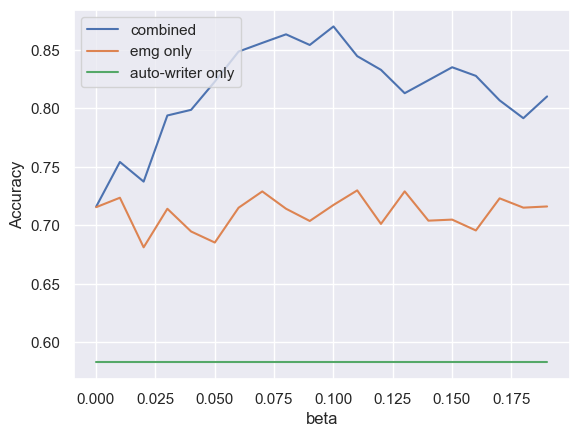

In [ ]:
# v3
comb = [accs['comb'] for accs in beta_accs.values()]
emg = [accs['emg'] for accs in beta_accs.values()]
auto = [accs['auto'] for accs in beta_accs.values()]
x = betas.numpy()
plt.plot(x, comb, label='combined')
plt.plot(x, emg, label='emg only')
plt.plot(x, auto, label='auto-writer only')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('beta')

In [318]:
[np.mean(a) for a in accs.values()] #0.005

[0.8644044, 0.8447262, 0.48894462]

In [ ]:
[np.mean(a) for a in accs.values()] #0.01

[0.883643, 0.8568901, 0.48894462]

In [ ]:
[np.mean(a) for a in accs.values()] #0.1

[0.6618649, 0.81724864, 0.48894462]

In [ ]:
[np.mean(a) for a in accs.values()] #0.05

[0.8271551, 0.8206725, 0.48894462]

Text(0.5, 1.0, 'Auto 0.24')

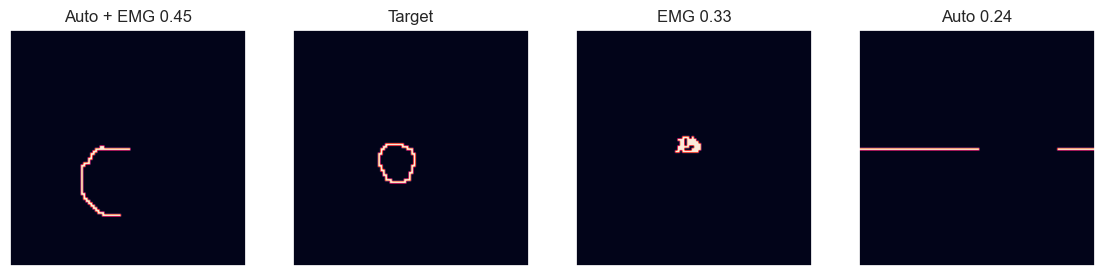

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(14,10))
plot_encoded_moves(history, canvas_size=100, ax=axs[0])
plot_encoded_moves(stroke, canvas_size=100, ax=axs[1])
plot_encoded_moves(emg_only_hist, canvas_size=100, ax=axs[2])
plot_encoded_moves(auto_only_hist, canvas_size=100, ax=axs[3])
axs[0].set_title(f'Auto + EMG {accuracy:.2f}')
axs[1].set_title('Target')
axs[2].set_title(f'EMG {emg_accuracy:.2f}')
axs[3].set_title(f'Auto {auto_accuracy:.2f}')

In [ ]:
# generate img with 

In [ ]:
# have comparison of emg accuracy vs outcome w autowriter